# Tâche 8: Le diagramme de bande

In [463]:
#telechargement du fichier CIF du matériau attribué
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifWriter #to write a Structure to various output formats
import numpy as np
from pymatgen import Spin
import math

In [690]:
#Cette fois-ci, il nous est demandé de telecharger la structure de bande
with MPRester("G0BptrHMmTXo23sw") as m:

    # To obtain information on a material (bandstructure) with Materials Project Id
    bs = m.get_bandstructure_by_material_id("mp-554310")

Dans cette section, nous allons déterminer la bande interdite,trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion et trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion. 

Pour réaliser cela, nous utiliserons le site [Matérials Project](https://materialsproject.org/materials/mp-554310/#) ainsi que les notes de cours du chapitre [Les électrons dans le cristal](https://moodleucl.uclouvain.be/pluginfile.php/1274329/mod_resource/content/3/Chap-4.pdf).

In [691]:
from pymatgen.electronic_structure.bandstructure import BandStructure
from pymatgen.electronic_structure.plotter import BSPlotter

Voici le graphique de bande électronique disponible sur matérials Project, les points rouges sont les minimums de la bande de conduction et les ronds verts les maximas de la bande de valence.

![title](https://raw.githubusercontent.com/Vahouben/lmapr1492/master/MPgraph.png)

Ainsi que celui obtenu en utilisant pymatgen:

<module 'matplotlib.pyplot' from '/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

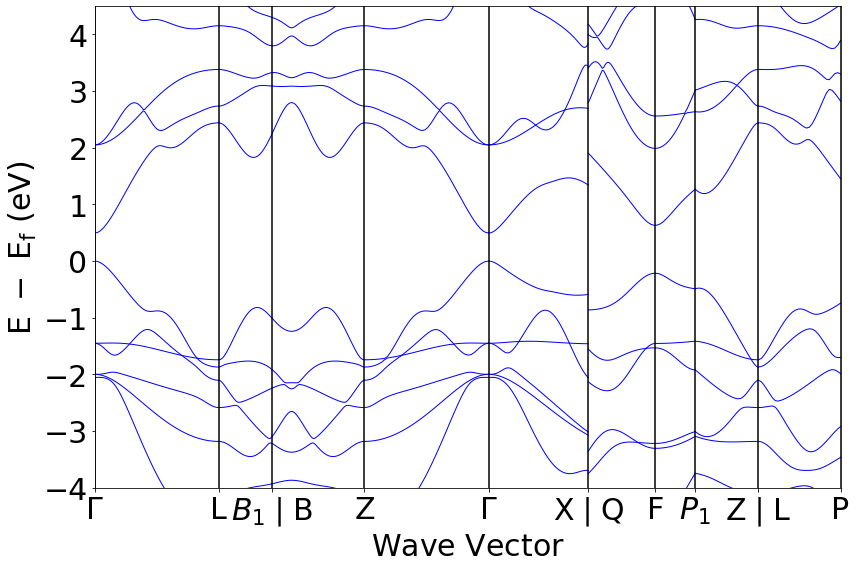

In [692]:
BSPlotter(bs).get_plot()

Et voici le diagramme de la zone de Brillouin afin de visualiser les positions des différents vecteurs d'onde:

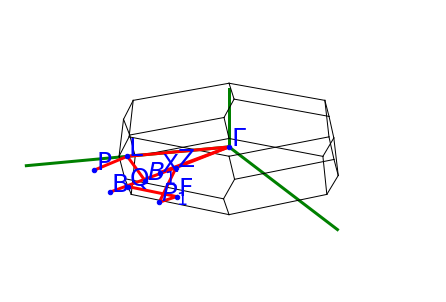

In [693]:
BSPlotter(bs).plot_brillouin()

## 1) Détermination de la bande interdite

In [694]:
gap=bs.get_direct_band_gap()
print("L'énergie de la bande interdite est de "+ str(gap) + "eV")

L'énergie de la bande interdite est de 0.49490000000000034eV


Cette valeur est supérieure à celle disponible sur matérials project (0.424 eV) qui précise que ses valeurs sont séverement sous-estimées en raison du [semi-local DFT](https://wiki.materialsproject.org/Calculations_Manual#Accuracy_of_Band_Structures).

Pour plus d'informations sur cette bande d'énergie interdite:

In [695]:
bs.get_band_gap()

{'direct': True,
 'energy': 0.49490000000000034,
 'transition': '\\Gamma-\\Gamma'}

Nous observons donc que cette bande d'énergie interdite est une bande directe et que la transition est une transition verticale $\Gamma -\Gamma$. (voir zone de Brillouin)

A température nulle, la bande de conduction est vide mais la bande interdite est faible (<10 eV). Notre solide est donc isolant à température nulle, une élévation de température permet de faire passer des électrons de la bande de valence à la bande de conduction. Nous avons donc affaire à un semi-conducteur.

Etant donné que la transition électronique est directe, les électrons sont excités de manière verticale, il n'y a pas de changement de vecteur d'onde.

## 2) Directions de dispertion

La dispertion est définie comme E(k), une grande ou une petite direction de dispersion se calculera donc en fonction du taux de variation de l'énergie lorsqu'on varie le vecteur k la direction ne notera d'un point de haute symétrie vers un autre (points critiques) et la dispertion en $\Delta E$. Pour parvenir a récuperer toutes les positions (k,E) j'ai utilisé ce documentaire: [Bandstructure](https://matgenb.materialsvirtuallab.org/2013/01/01/Bandstructure-of-NiO.html?fbclid=IwAR1ADN_AZPpWMu6W0dRtzT77TL1qXFVC51C0DR27QE_Y_BvgtCKSNXRUlCk) qui montre un bel exemple d'utilisation de pymatgen.

Pour faire cela, on peut tout simplement le faire visuellement en regardant le diargramme de l'énergie en fonction du vecteur d'onde, il est également possible par après de vérifier ces directions à l'aide de quelques (beaucoup) de lignes de code. Sur le diagramme ci-dessous, les flèches vertes montrent des minimums de dispersion et les flèches rouges les maximas de dispersion.

![title](https://raw.githubusercontent.com/Vahouben/lmapr1492/master/mm.png)

In [696]:
#pour connaitre le nombre de kpoint par bande: 
bs.bands[Spin.up].shape
#on apprend qu'il y a 24 bande de 527 kpoint

(24, 572)

### Dans laquelle la dernière bande de valence présente le plus et le moins de dispersion:

In [697]:
#Avoir tous les kpoints de notre matériau
kpoints=bs.kpoints
#avoir l'index de la dernière bande de valence
vbm=bs.get_vbm()
Im=vbm['band_index']
print(Im)

defaultdict(<class 'list'>, {<Spin.up: 1>: [14]})


L'index de la dernière bande de valence est donc 14 constituée de spin up.

In [698]:
#La 14 eme bande de spin up est:
valence=bs.bands[Spin.up][14, :]

#### Minimum

In [699]:
#on pose la pente intiale infinie pour permettre une comparaison
#ainsi que les variables dans lequelles on stockera valeurs trouvés au fur et à mesure
pentemin=1000000
n=0
e1=0
Kmin1
Kmin2
#On prend le premier point comme point de depart car c'est d'office un point critique
for kpoints, e in zip(bs.kpoints, valence):
    n += 1
    if n==1:
        Kmin1=kpoints
        e1=e
#on initialise les premieres valeurs en se basant sur les 2 premiers kpoints
eprev=e1
Kprev=Kmin1
n=0
nprev=0
for kpoints, e in zip(bs.kpoints, valence):
    if kpoints.label != None:
        n+=1
        a=kpoints.frac_coords
        k=a[0]**2+a[1]**2+a[2]**2
        d=k-kprev
        en=e-eprev
        if d!=0.0:
            pente=en/d
#ici la condition d'entée est un peu plus difficile, il faut faire attention car
#la manière dont sont donnée les informations peuvent présenter des problèmes dans le 
#cas de la recherche d'un minima car il y a redondance des vecteurs critiques.
            if (Kprev.frac_coords[0]!=a[0]and pente!=0 and abs(pente)<abs(pentemin)):
                pentemin=pente
                Kmin1=Kprev
                Kmin2=kpoints
        Kprev=kpoints
        eprev=e
        kprev=k
    else:
        continue

print("La dernière bande de valence présente le moins de dispersion dans la direction "+ Kmin1.label + " à " + Kmin2.label) 

La dernière bande de valence présente le moins de dispersion dans la direction F à P_1


#### Maximum

In [700]:
#toutes mes excuses aux lecteurs, je n'ai pas trouvé de code plus agréable 
#on pose deux pentes pour permettre une comparaison
#ainsi que les variables dans lequelles on stockera les kpoint trouvés
pentemax=0
n=0
Kmax1
Kmax2
e1=0
#cette fonction permet de tirer les valeurs de k point dans la bande et est tirée du site ci dessus:
for kpoints, e in zip(bs.kpoints, valence):
    n += 1
    if n==1:
        Kmax1=kpoints
        e1=e
#on initialise les premieres valeurs en se basant sur les 2 premiers kpoints
Kprev=Kmax1
eprev=e1
for kpoints, e in zip(bs.kpoints, valence):
    if kpoints.label != None:
        a=kpoints.frac_coords
        k=a[0]**2+a[1]**2+a[2]**2
        d=k-kprev
        en=e-eprev
        if d!=0:
            pente=en/d
            if abs(pente)>=abs(pentemax):
                pentemax=pente
                Kmax1=Kprev
                Kmax2=kpoints
            Kprev=kpoints
            eprev=e
            kprev=k
    else:
        continue
    
print("La dernière bande de valence présente le plus de dispersion dans la direction "+ Kmax1.label + " à " + Kmax2.label) 

La dernière bande de valence présente le plus de dispersion dans la direction Q à F


### Dans laquelle la première bande de conduction présente le plus et le moins de dispersion:

In [701]:
#avoir l'index de la premiere bande de conduction
cbm=bs.get_cbm()
Ic=cbm['band_index']
print(Ic)

defaultdict(<class 'list'>, {<Spin.up: 1>: [15]})


L'index de la première bande de conduction est 15 constituée de spin up

In [702]:
conduction=bs.bands[Spin.up][15, :]

#### Minimum

In [703]:
#on pose la pente intiale infinie pour permettre une comparaison
#ainsi que les variables dans lequelles on stockera valeurs trouvés au fur et à mesure
pentemin=10000
Kmin1
Kmin2
Kprev
n=0
e1=0
#cette fonction permet de tirer les valeurs de k point dans la bande et est tirée du site ci dessus:
for kpoints, e in zip(bs.kpoints, conduction):
    n += 1
    if n==1:
        Kmin1=kpoints
        e1=e
#on initialise les premieres valeurs en se basant sur les 2 premiers kpoints
eprev=e1
for kpoints, e in zip(bs.kpoints, conduction):
    if kpoints.label != None:
        a=kpoints.frac_coords
        k=a[0]**2+a[1]**2+a[2]**2
        d=k-kprev
        en=e-eprev
        if (d!=0.0 and en!=0):
            pente=en/d
            if abs(pente)<abs(pentemin):
                pentemin=pente
                Kmin1=Kprev
                Kmin2=kpoints
        Kprev=kpoints
        eprev=e
        kprev=k
    else:
        continue

print("La première bande de conduction présente le moins de dispersion dans la direction "+ Kmin1.label + " à " + Kmin2.label) 

La première bande de conduction présente le moins de dispersion dans la direction B à Z


#### Maximum

In [704]:
#on pose deux pentes pour permettre une comparaison
#ainsi que les variables dans lequelles on stockera les kpoint trouvés
pentemax=0
n=0
Kmax1
Kmax2
e1=0
e2=0
#cette fonction permet de tirer les valeurs de k point dans la bande et est tirée du site ci dessus:
for kpoints, e in zip(bs.kpoints, conduction):
    n += 1
    if n==1:
        Kmax1=kpoints
        e1=e
#on initialise les premieres valeurs en se basant sur les 2 premiers kpoints
Kprev=Kmax1
eprev=e1
for kpoints, e in zip(bs.kpoints, conduction):
    if kpoints.label != None:
        a=kpoints.frac_coords
        k=a[0]**2+a[1]**2+a[2]**2
        d=k-kprev
        en=e-eprev
        if d!=0.0:
            pente=en/d
            if abs(pente)>=abs(pentemax):
                pentemax=pente
                Kmax1=Kprev
                Kmax2=kpoints
            Kprev=kpoints
            eprev=e
            kprev=k
    else:
        continue
print("La première bande de conduction présente le plus de dispersion dans la direction "+ Kmax1.label + " à " + Kmax2.label)

La première bande de conduction présente le plus de dispersion dans la direction Q à F


## 3) Calcul de la masse effective

Pour cette question, nous supposons une dispersion parabolique. Nous utilisons donc comme équation pour l'énergie: $$ E(k)=\frac{\hbar^2 \times k^2}{2\times m_{eff}} $$
Ce qui nous permet d'isoler la masse effective. 
$$ m_{eff}=\frac{\hbar^2 \times k^2}{2\times E(k)} $$
Etant donné que le vecteur k est à 3 dimentions:
$$ m_{eff}=\frac{\hbar^2 \times (k_x^2+k_y^2+k_z^2)}{2\times E(k)} $$

In [705]:
#hbar en [js]
bar=1.054571817e-34

In [706]:
#hbar en [eVs]
hbar=bar/1.602176634e-19

In [707]:
ef=bs.efermi

Comme nous rencontrons comme problème que k est égal à zéro, nous pouvons utiliser la formule $$ m_{eff}=\frac{\hbar^2 \times (k+K)^2}{2\times E(k)} $$ K étant le vecteur du réseau réciproque, en 3 dimentions. Nous avions calculé K dans la tâche 1: $K=pa^*+qb^*+mb^*$. Avec p, q et m appartenant à l'ensemble des entiers. Nous savons également selon les développements du cours que $\epsilon_k=\epsilon_{k+K}$ (répétition des énergies dans le réseau réciproque)

In [708]:
#ces chiffres sont repris dans la tache 1:
astar=[ 1.56933045e+00, -8.16321233e-01, -4.59908211e-04]
bstar=[-1.27774900e-04, 1.76894836, -4.59906674e-04]
cstar=[-1.34467432, -0.81632108, 0.80910408]

In [709]:
#nous définissons le vecteur K étant le plus court dans la direction de cstar soit (p,q,m)= (0,0,1)
K=cstar

### Au sommet de la dernière bande de valence:

In [710]:
vbm=bs.get_vbm()

In [711]:
kpointv=vbm['kpoint']
E1=vbm['energy']
print("le vecteur d'onde k est donc bien de norme 0: "+ str(kpointv.cart_coords))

le vecteur d'onde k est donc bien de norme 0: [0. 0. 0.]


In [330]:
m_effv=((hbar**2)*(K[0]**2+K[1]**2+K[2]**2))/(2*E1)

In [347]:
print(str(m_effv) +" kg")

1.5110283514170148e-31 kg


La valeur obtenue correspond bien aux valeurs attendues, en effet, comme on peut le voir sur le power point [masse effective](https://wiki.epfl.ch/houdre/documents/DispElec/chapitre%2002%20bandes.pdf), slide 59, le rapport masse effective sur masse de l'electron est aux alentours de $10^{-1} - 10^{-2}$ Ce que nous obtenons.

In [348]:
m_el=9.110e-31
print(str(m_effv/m_el))

0.16586480257047362


### A la base de la première bande de conduction:

In [349]:
cbm=bs.get_cbm()

In [350]:
kpointc=cbm['kpoint']
E2=cbm['energy']
print("le vecteur d'onde k est donc bien de norme 0: "+ str(kpointc.frac_coords))

le vecteur d'onde k est donc bien de norme 0: [0. 0. 0.]


In [351]:
m_effc=((hbar**2)*(K[0]**2+K[1]**2+K[2]**2))/(2*E2)

In [352]:
print(str(m_effc) +" kg")

1.3608932491029187e-31 kg


### Remarque

Théoriquement, cette démarche mathématique devrait être identique pour n'importe quel Vecteur de réseau K, hors, losqu'on utilise d'autres entiers (p,q,m) on obtient des valeurs légèrements différentes:

In [353]:
#exemple dans le cas de la bande de conduction
#(p,q,m)=(1,0,1)
K2=cstar+astar
#(p,q,m)=(1,0,0)
K3=astar
m_effc2=((hbar**2)*(K2[0]**2+K2[1]**2+K2[2]**2))/(2*E2)
m_effc3=((hbar**2)*(K3[0]**2+K3[1]**2+K3[2]**2))/(2*E2)

In [354]:
print(str(m_effc2) +" kg")

1.3608932491029187e-31 kg


In [355]:
print(str(m_effc3) +" kg")

1.3608932854030468e-31 kg


La différence est très légère, mais nous gardons le même ordre de grandeur, cela signifie qu'utiliser l'hypothèse de dispersion parabolique n'est pas tout a fait juste mais que cela nous approche bien de la réalité.